<a href="https://colab.research.google.com/github/inefable12/fedfo_720/blob/main/Hypothesis_fedfo720.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
import json
from tqdm import tqdm

In [2]:
def log_to_json(log_data, file_path='test_log.json'):
    with open(file_path, 'w') as file:
        json.dump(log_data, file)

def multivariate_hypothesis_test(df1, df2, log, ite, alpha = 0.05):
    # Teste de pressupostos: Teste de Shapiro-Wilk para normalidade
    _, p_normality_df1 = stats.shapiro(df1)
    _, p_normality_df2 = stats.shapiro(df2)
    log[f'normality_test_{ite}'] = {
        'df1': p_normality_df1,
        'df2': p_normality_df2
    }

     # Nível de significância
    if p_normality_df1 > alpha and p_normality_df2 > alpha:
        log[f'normality_result_{ite}'] = 'Both groups are normally distributed'
        # Aplicar teste paramétrico: MANOVA
        from statsmodels.multivariate.manova import MANOVA
        combined_df = pd.concat([df1, df2])
        group_labels = ['Group1'] * len(df1) + ['Group2'] * len(df2)
        manova = MANOVA.from_formula(' ~ '.join(['C(group_labels)'] + list(combined_df.columns)), data=combined_df)
        manova_result = manova.mv_test()
        log[f'test_result_{ite}'] = str(manova_result)
    else:
        log[f'normality_result_{ite}'] = 'At least one group is not normally distributed'
        # Aplicar teste não paramétrico: Kruskal-Wallis H-test
        kruskal_result = stats.kruskal(df1, df2)
        log[f'test_result_{ite}'] = str(kruskal_result)

    # Verificação da significância
    if 'p-value' in log[f'test_result_{ite}'] and log[f'test_result_{ite}'][f'p-value_{ite}'] < alpha:
        log[f'significance_result_{ite}'] = 'Evidence to reject the null hypothesis (groups are different)'
    else:
        log[f'significance_result_{ite}'] = 'No evidence to reject the null hypothesis (groups are similar)'

    return log

def balance_dataframes(df1, df2, method = "Undersampling"):


    # Aplicar o método de balanceamento
    if method == 'Undersampling':
        balanced_df1 = df1.sample(n=count_df2)
        balanced_df2 = df2
    elif method == 'Oversampling':
        balanced_df2 = df2.sample(n=count_df1, replace=True)
        balanced_df1 = df1
    elif method == 'SMOTE':
        smote = SMOTE()
        combined_df = pd.concat([df1, df2])
        features = combined_df.iloc[:, :-1]
        labels = combined_df.iloc[:, -1]
        features_resampled, labels_resampled = smote.fit_resample(features, labels)
        balanced_df1 = features_resampled[labels_resampled == labels.unique()[0]]
        balanced_df2 = features_resampled[labels_resampled == labels.unique()[1]]

    return balanced_df1, balanced_df2, method

def partition_dataframe(df, threshold):
    # Seleciona as linhas onde o valor na última coluna é maior que o limiar
    group1 = df[df.iloc[:, -1] > threshold]

    # Seleciona as linhas onde o valor na última coluna é menor ou igual ao limiar
    group2 = df[df.iloc[:, -1] <= threshold]

    return group1, group2


In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/inefable12/fedfo_720/main/FULLc.csv")

## Partitioning the groups

In [4]:
group1, group2 = partition_dataframe(df, threshold=-6) # using energy = -6 as thresholding

In [5]:
group1.shape, group2.shape

((28, 24), (692, 24))

## Critério de sample

In [6]:
count_df1 = len(group1)
count_df2 = len(group2)

# Definir o método de balanceamento
teste = abs(count_df1 - count_df2) / max(count_df1, count_df2)
if teste < 0.20:
    method = 'SMOTE'
elif count_df1 > count_df2:
    method = 'Undersampling'
else:
    method = 'Oversampling'

In [7]:
method

'Oversampling'

## Sample

In [8]:
balanced_df1, balanced_df2,  method = balance_dataframes(group1, group2, method=method)

In [9]:
method, balanced_df1.shape, balanced_df2.shape

('Oversampling', (28, 24), (28, 24))

## Teste único

In [11]:
#log = multivariate_hypothesis_test(balanced_df1, balanced_df2)

In [28]:
def multipleTests(df, threshold=-5.5, method='Oversampling', ite=1000, alpha=0.01):

  group1, group2 = partition_dataframe(df, threshold=threshold)

  bin = []
  log = {}
  for i in tqdm(range(ite+1)):
    balanced_df1, balanced_df2,  method = balance_dataframes(group1.iloc[:,:-1].copy(), group2.iloc[:,:-1].copy(), method=method)
    log = multivariate_hypothesis_test(balanced_df1, balanced_df2, log, i, alpha = alpha)
    if 'groups are different' in log[f'significance_result_{i}']:
      bin.append(0)
    elif 'groups are similar' in log[f'significance_result_{i}']:
      bin.append(1)
    else:
      bin.append(-99)
  # Gravação dos resultados em arquivo JSON
  log_to_json(log)

  return log, bin

In [29]:
log, bin = multipleTests(df.copy(), threshold=-5.5, method='Oversampling', ite=1000, alpha=0.05)

100%|██████████| 1001/1001 [00:15<00:00, 66.32it/s]


(array([   0.,    0.,    0.,    0.,    0., 1001.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

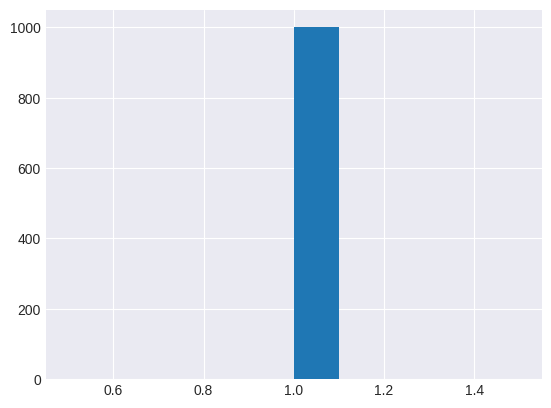

In [36]:
plt.hist(bin)

In [32]:
999 in bin

False

### Looking one particular result

In [21]:
i = 4
print(log[f'significance_result_{i}'])
print("\n ____ \n")
print(log[f'test_result_{i}'])

No evidence to reject the null hypothesis (groups are similar)

 ____ 

KruskalResult(statistic=array([6.99822408e-01, 1.96365244e+00, 1.22862571e+00, 1.42099974e+00,
       1.27535710e+00, 2.95658917e-01, 1.92878081e-01, 1.57451494e-02,
       2.14308978e+00, 5.35772446e-01, 9.84071840e-02, 3.46317087e-01,
       8.46739147e-01, 1.57451494e-02, 2.14308978e-02, 1.74946105e-03,
       9.84071840e-02, 6.29805977e-02, 2.14308978e-02, 7.39147293e-02,
       1.09341316e-02, 2.79913768e-02, 3.67824185e-01]), pvalue=array([0.40284337, 0.16112323, 0.26767447, 0.23323892, 0.25876409,
       0.58661678, 0.66053193, 0.90014381, 0.14321319, 0.46419006,
       0.75374951, 0.55620538, 0.35747646, 0.90014381, 0.88361119,
       0.96663696, 0.75374951, 0.80184553, 0.88361119, 0.78571995,
       0.91671988, 0.8671291 , 0.54419267]))


Normalmente são aplicados depois do teste que aplicamos para ver quais são as diferenças. Como não houve diferença não aplicamos:

1. Dunn's test

2. Teste de Conover

In [ ]:
df.describe()

,r_mopac_Alpha_LUMO_Energy,r_mopac_Alpha_SOMO_Energy,r_mopac_Beta_LUMO_Energy,r_mopac_Beta_SOMO_Energy,r_mopac_Dipole,r_mopac_Dipole_X,r_mopac_Dipole_Y,r_mopac_Dipole_Z,r_mopac_Ionization_Energy,r_mopac_MOPAC_Heat_of_Formation,...,PMI2,PMI3,NPR1,NPR2,RadiusOfGyration,InertialShapeFactor,Eccentricity,Asphericity,SpherocityIndex,FEBc
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,...,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,-3.346396,-10.271513,-3.369017,-10.385749,25.435086,-0.043914,0.840166,-0.229455,10.206133,-242.123998,...,11071.351626,14358.119994,0.374601,0.719167,4.813279,0.000158,0.891999,0.287884,0.176714,-9.309444
std,0.672989,0.727768,0.684501,0.663514,12.828885,7.783168,22.432630,15.743620,0.683046,23.820317,...,6992.197885,6582.053676,0.138595,0.151691,1.146340,0.000076,0.145767,0.176962,0.082379,1.630301
min,-4.216000,-11.963000,-4.357000,-11.768000,1.065645,-20.076334,-42.872215,-33.696211,8.822696,-298.510162,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.500000
25%,-4.002000,-10.943500,-4.009000,-11.075250,13.145264,-4.828230,-18.771458,-12.806037,9.566224,-264.950308,...,7502.531911,11134.453195,0.323234,0.661651,4.392466,0.000123,0.879247,0.189268,0.122673,-10.300000
50%,-3.580000,-10.074000,-3.739500,-10.155500,24.570876,0.012265,0.823812,-0.523882,10.016156,-231.226396,...,8226.454943,11857.017792,0.416329,0.707756,4.508214,0.000137,0.907037,0.228205,0.167015,-9.600000
75%,-2.668750,-9.580250,-2.692000,-9.806000,38.126300,4.615344,21.882226,12.211842,10.860869,-223.142081,...,11856.245750,16302.905511,0.469047,0.762209,5.225804,0.000162,0.941319,0.312413,0.217665,-8.300000
max,-2.017000,-9.135000,-2.000000,-8.823000,46.409121,20.454318,40.948196,33.939945,11.767690,-171.368276,...,43196.776378,44006.822154,0.623916,0.996984,8.572740,0.000651,0.999330,0.894813,0.522928,-3.500000


In [22]:
# Suponha que df seja seu DataFrame existente
# Inicializa listas para armazenar os resultados
columns = []
shapiro_stats = []
p_values = []

# Executa o teste de Shapiro-Wilk em cada coluna e armazena os resultados
for column in df.columns:
    stat, p_value = stats.shapiro(df[column])
    columns.append(column)
    shapiro_stats.append(stat)
    p_values.append(p_value)

# Cria um novo DataFrame com os resultados
shapiro_results = pd.DataFrame({
    'Column': columns,
    'Shapiro Stat': shapiro_stats,
    'P-value': p_values
})

# Adiciona uma coluna para interpretar a normalidade
alpha = 0.05
shapiro_results['Normal'] = shapiro_results['P-value'] > alpha

In [23]:
shapiro_results

,Column,Shapiro Stat,P-value,Normal
0,r_mopac_Alpha_LUMO_Energy,0.834343,1.126888e-26,False
1,r_mopac_Alpha_SOMO_Energy,0.904148,7.738164e-21,False
2,r_mopac_Beta_LUMO_Energy,0.832039,7.844109e-27,False
3,r_mopac_Beta_SOMO_Energy,0.911851,5.183205e-20,False
4,r_mopac_Dipole,0.894959,9.236597e-22,False
5,r_mopac_Dipole_X,0.994242,7.752288e-03,False
6,r_mopac_Dipole_Y,0.950629,8.656487e-15,False
7,r_mopac_Dipole_Z,0.971505,1.253032e-10,False
8,r_mopac_Ionization_Energy,0.903782,7.089097e-21,False
9,r_mopac_MOPAC_Heat_of_Formation,0.929750,7.276676e-18,False


<ipython-input-24-59f9a7bf40cd>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


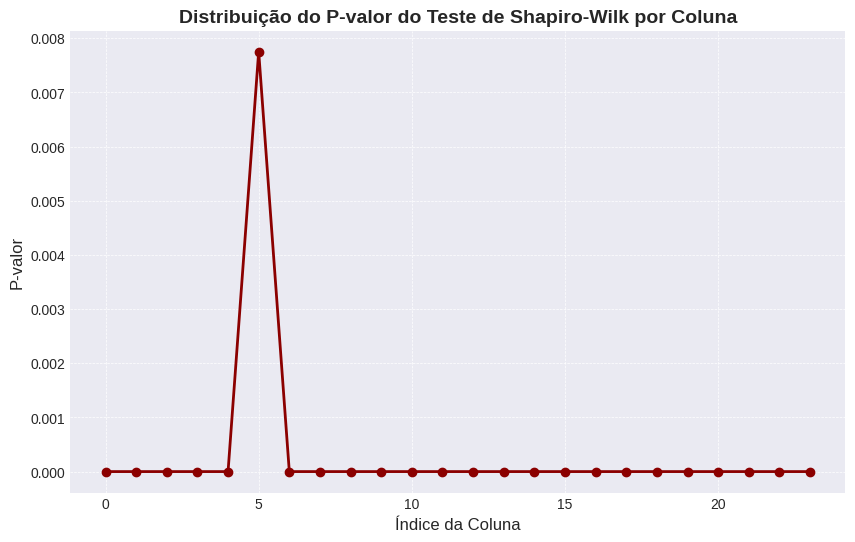

In [24]:
from matplotlib import pyplot as plt

# Definindo o estilo do gráfico
plt.style.use('seaborn-darkgrid')

# Criando o gráfico
shapiro_results['P-value'].plot(
    kind='line',
    figsize=(10, 6),
    title='Distribuição do P-valor do Teste de Shapiro-Wilk por Coluna',
    linewidth=2,
    marker='o',
    color='darkred'
)

# Adicionando rótulos aos eixos
plt.xlabel('Índice da Coluna', fontsize=12)
plt.ylabel('P-valor', fontsize=12)

# Configurando o título
plt.title('Distribuição do P-valor do Teste de Shapiro-Wilk por Coluna', fontsize=14, fontweight='bold')

# Configurando as bordas e spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Melhorando a legibilidade do gráfico
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adicionando linhas de grade para melhor visualização
plt.grid(True, linestyle='--', linewidth=0.5)

# Exibindo o gráfico
plt.show()


<ipython-input-25-c2a1c33e4f25>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


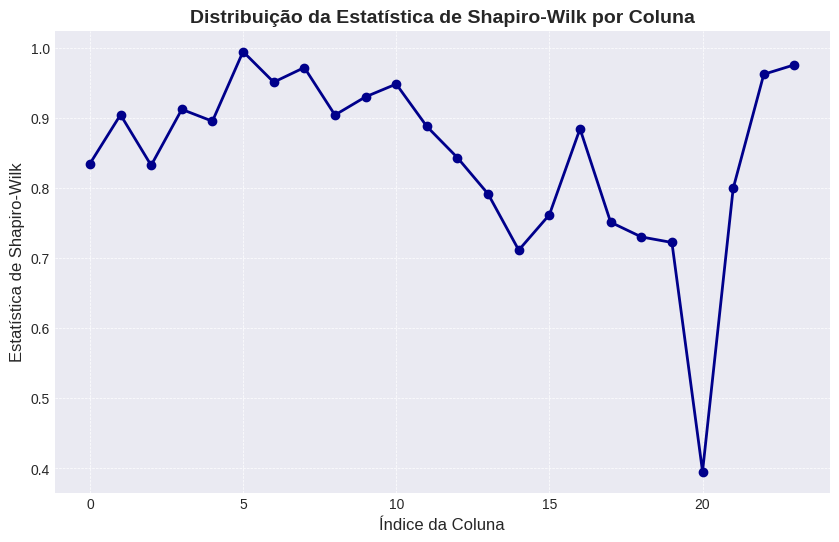

In [25]:
# @title Shapiro Stat

from matplotlib import pyplot as plt

# Definindo o estilo do gráfico
plt.style.use('seaborn-darkgrid')

# Criando o gráfico
shapiro_results['Shapiro Stat'].plot(
    kind='line',
    figsize=(10, 6),
    title='Distribuição da Estatística de Shapiro-Wilk por Coluna',
    linewidth=2,
    marker='o',
    color='darkblue'
)

# Adicionando rótulos aos eixos
plt.xlabel('Índice da Coluna', fontsize=12)
plt.ylabel('Estatística de Shapiro-Wilk', fontsize=12)

# Configurando o título
plt.title('Distribuição da Estatística de Shapiro-Wilk por Coluna', fontsize=14, fontweight='bold')

# Configurando as bordas e spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Melhorando a legibilidade do gráfico
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adicionando a grade
plt.grid(True, linestyle='--', linewidth=0.5)

# Exibindo o gráfico
plt.show()


In [26]:
import pandas as pd

# Supondo que df seja o seu DataFrame
summary = df.describe()

# Selecione estatísticas chave
key_stats = summary.loc[['mean', 'std', 'min', '50%', 'max']]

# Para simplificar ainda mais, você pode calcular a amplitude (range)
key_stats.loc['range'] = key_stats.loc['max'] - key_stats.loc['min']

# Agora, key_stats contém um resumo simplificado
print(key_stats)


       r_mopac_Alpha_LUMO_Energy  r_mopac_Alpha_SOMO_Energy  \
mean                   -3.346396                 -10.271513   
std                     0.672989                   0.727768   
min                    -4.216000                 -11.963000   
50%                    -3.580000                 -10.074000   
max                    -2.017000                  -9.135000   
range                   2.199000                   2.828000   

       r_mopac_Beta_LUMO_Energy  r_mopac_Beta_SOMO_Energy  r_mopac_Dipole  \
mean                  -3.369017                -10.385749       25.435086   
std                    0.684501                  0.663514       12.828885   
min                   -4.357000                -11.768000        1.065645   
50%                   -3.739500                -10.155500       24.570876   
max                   -2.000000                 -8.823000       46.409121   
range                  2.357000                  2.945000       45.343476   

       r_mopac_Dip

In [27]:
key_stats

,r_mopac_Alpha_LUMO_Energy,r_mopac_Alpha_SOMO_Energy,r_mopac_Beta_LUMO_Energy,r_mopac_Beta_SOMO_Energy,r_mopac_Dipole,r_mopac_Dipole_X,r_mopac_Dipole_Y,r_mopac_Dipole_Z,r_mopac_Ionization_Energy,r_mopac_MOPAC_Heat_of_Formation,...,PMI2,PMI3,NPR1,NPR2,RadiusOfGyration,InertialShapeFactor,Eccentricity,Asphericity,SpherocityIndex,FEBc
mean,-3.346396,-10.271513,-3.369017,-10.385749,25.435086,-0.043914,0.840166,-0.229455,10.206133,-242.123998,...,11071.351626,14358.119994,0.374601,0.719167,4.813279,0.000158,0.891999,0.287884,0.176714,-9.309444
std,0.672989,0.727768,0.684501,0.663514,12.828885,7.783168,22.432630,15.743620,0.683046,23.820317,...,6992.197885,6582.053676,0.138595,0.151691,1.146340,0.000076,0.145767,0.176962,0.082379,1.630301
min,-4.216000,-11.963000,-4.357000,-11.768000,1.065645,-20.076334,-42.872215,-33.696211,8.822696,-298.510162,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.500000
50%,-3.580000,-10.074000,-3.739500,-10.155500,24.570876,0.012265,0.823812,-0.523882,10.016156,-231.226396,...,8226.454943,11857.017792,0.416329,0.707756,4.508214,0.000137,0.907037,0.228205,0.167015,-9.600000
max,-2.017000,-9.135000,-2.000000,-8.823000,46.409121,20.454318,40.948196,33.939945,11.767690,-171.368276,...,43196.776378,44006.822154,0.623916,0.996984,8.572740,0.000651,0.999330,0.894813,0.522928,-3.500000
range,2.199000,2.828000,2.357000,2.945000,45.343476,40.530652,83.820411,67.636156,2.944994,127.141886,...,43196.776378,44006.822154,0.623916,0.996984,8.572740,0.000651,0.999330,0.894813,0.522928,10.000000
